# Simple introduction to retrieval-augmented generation with watsonx.ai

## Notebook content

This notebook contains the steps and code to demonstrate the retrieval-augmented generation pattern in IBM watsonx.ai.

Some familiarity with Python is helpful. This notebook uses Python 3.10.


## Learning goal

The goal of this notebook is to demonstrate how to apply the retrieval-augmented generation pattern to a question-answering use case in watsonx.ai.


## Scenario
The website for an online seed catalog has many articles to help customers plan their garden and ultimately select which seeds to purchase. A new widget is being added to the website to answer customer questions based on the contents of the articles.


## Contents

This notebook contains the following parts:

- [Overview of retrieval-augmented generation](#overview)
- [Step 1: Set up prerequisites](#setup)
- [Step 2: Create a knowledge base](#knowledgebase)
- [Step 3: Build a simple search component](#search)
- [Step 4: Craft prompt text](#prompt)
- [Step 5: Generate output using the foundation models Python library](#generate)
- [Step 6: Pull everything together to perform retrieval-augmented generation](#rag)
- [Summary](#summary)

<a id="overview"></a>
## Overview of retrieval-augmented generation

The retrieval-augmented generation pattern involves three basic steps:
1. Search for relevant content in your knowledge base
2. Pull the most relevant content into your prompt as context
3. Send the combined prompt text to a foundation model to generate output

The term _retrieval-augmented generation_ (RAG) was introduced in this paper: <a href="https://arxiv.org/abs/2005.11401" target="_blank" rel="noopener no referrer">Retrieval-augmented generation for knowledge-intensive NLP tasks</a>

> "We build RAG models where the parametric memory is a pre-trained seq2seq transformer, and the
non-parametric memory is a dense vector index of Wikipedia, accessed with a pre-trained neural
retriever."

In that paper, the term "RAG models" refers to a specific implementation of a _retriever_ (a specific query encoder and vector-based document search index) and a _generator_ (a specific pre-trained, generative language model.) 

However, the basic search-and-generate approach can be generalized to use different retriever components and foundation models.

In this notebook:
- The **knowledge base** is a list of two articles
- The **retrieval component** consists of a simple search function
- The **generate** component uses the foundation model Python library in watsonx.ai


<a id="setup"></a>

# Step 1: Set up prerequisites

Before you use the sample code in this notebook, you must perform the following setup tasks based on the platform that you are using:

## For IBM watsonx on IBM Cloud only
- Create an IBM Cloud API key
- Associate the Watson Machine Learning instance with the current project

## For IBM watsonx.ai on Cloud Pak for Data
- Create a Cloud Pak for Data platform API key


# For IBM watsonx on IBM Cloud

## Create an IBM Cloud API key

Create an IBM Cloud API key by following these instructions: <a href="https://cloud.ibm.com/docs/account?topic=account-userapikey&interface=ui#create_user_key" target="_blank" rel="noopener no referrer">Creating an IBM Cloud API key</a>

## Associate an instance of the Watson Machine Learning service with the current project

The _current project_ is the project in which you are running this notebook.

If an instance of Watson Machine Learning is not already associated with the current project, follow the instructions in this topic to do so: <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/getting-started/assoc-services.html?context=wx&audience=wdp" target="_blank" rel="noopener no referrer">Adding associated services to a project</a>. If you don't have a Watson Machine Learning instance provisioned yet, you can create an new instance from there.

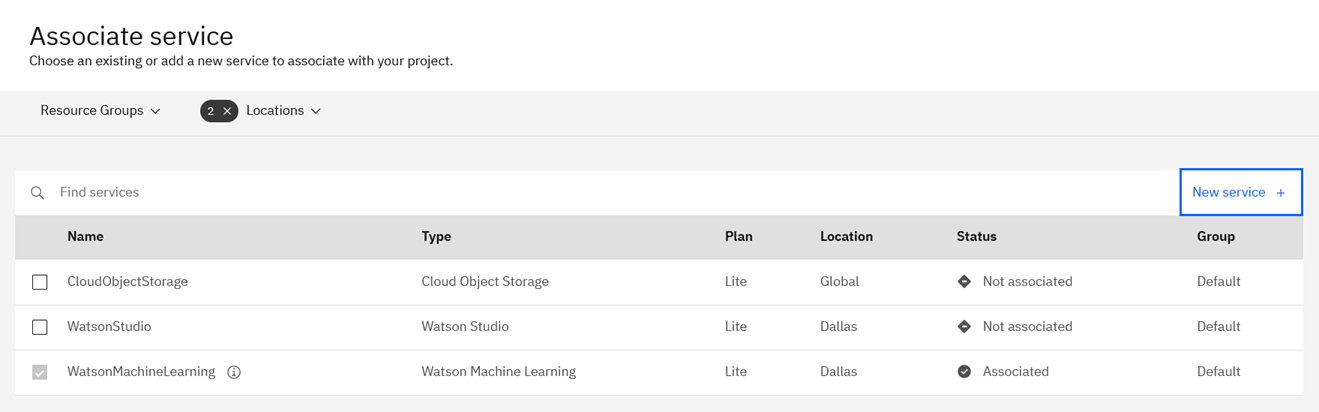

## Run the cell to provide the IBM Cloud API key

Run the following cell to provide the required information.

In [ ]:
# For IBM watsonx on IBM Cloud

import getpass

cloud_apikey = getpass.getpass("Type your IBM Cloud API key: ")

url = "https://us-south.ml.cloud.ibm.com"

## Run the cell to set the credentials for IBM watsonx on IBM Cloud

In [ ]:
# For IBM watsonx on IBM Cloud

credentials = { 
    "url"    : url, 
    "apikey" : cloud_apikey
}

# For IBM watsonx.ai on Cloud Pak for Data

Create a Cloud Pak for Data platform API key by following these instructions:

1. Click your profile icon.
1. Click **Profile and settings**.
1. Click **API key > Generate new key**.
1. Click **Generate**.
1. Click **Copy**.
1. Save the API key for future use.
1. Close the dialog box.

## Run the cell to provide the platform API key, url (hostname), and username

Run the following cell to provide the required information.

In [1]:
# For IBM watsonx.ai on Cloud Pak for Data

import getpass

cloud_apikey = getpass.getpass("Type your Cloud Pak for Data platform key: ")

url = input("Type the Cloud Pak for Data host name beginning with `https://`: ")

username = input("Type your Cloud Pak for Data username: ")

Type your Cloud Pak for Data platform key: ········
Type the Cloud Pak for Data host name beginning with `https://`: https://cpd-cpd-instance.watsonx-cpd-ypqa-179e80faa211a057bc402ed08a8d5eeb-0000.us-east.containers.appdomain.cloud
Type your Cloud Pak for Data username: sdaryn


## Run the cell to set the credentials for IBM watsonx.ai on Cloud Pak for Data

In [2]:
# For IBM watsonx.ai on Cloud Pak for Data

credentials = {
    "username": username,
    "apikey": cloud_apikey,
    "instance_id" : "openshift",
    "url": url,
    "version": "4.8"
}

<a id="knowledgebase"></a>
# Step 2: Create a knowledge base

In this notebook, the knowledge base is a collection of two articles.  

(These articles were written as samples for watsonx.ai, they are not real articles published anywhere else.  The authors and publication dates are fictional.)

In [ ]:
article_01 = \
"Tomatoes are one of the most popular plants for vegetable gardens.  Tip for success: If you select " \
"varieties that are resistant to disease and pests, growing tomatoes can be quite easy.  For "        \
"experienced gardeners looking for a challenge, there are endless heirloom and specialty varieties "  \
"to cultivate.  Tomato plants come in a range of sizes.  There are varieties that stay very small, "  \
"less than 12 inches, and grow well in a pot or hanging basket on a balcony or patio.  Some grow "    \
"into bushes that are a few feet high and wide, and can be grown is larger containers.  Other "       \
"varieties grow into huge bushes that are several feet wide and high in a planter or garden bed.  "   \
"Still other varieties grow as long vines, six feet or more, and love to climb trellises.  Tomato "   \
"plants do best in full sun.  You need to water tomatoes deeply and often.  Using mulch prevents "    \
"soil-borne disease from splashing up onto the fruit when you water.  Pruning suckers and even "      \
"pinching the tips will encourage the plant to put all its energy into producing fruit."

In [ ]:
article_02 = \
"Cucumbers are fun to grow for beginning gardeners and advanced gardeners alike.  There are two "     \
"types of cucumbers: slicing and pickling.  Pickling cucumbers are smaller than slicing cucumbers.  " \
"Cucumber plants come in two types: vining cucumbers, which are more common, and bush cucumbers.  "   \
"Vining cucumbers, which can grow to more than 5 feet tall, grow fast, yield lots of fruit, and you " \
"can train them up a trellis.  Growing cucumbers up a trellis or fence can maximize garden space, "   \
"keep fruit clean, and make it easier to harvest the fruit.  Tropical plants, cucumbers are very "    \
"sensitive to frost or cold weather. Cucumbers prefer full sun for 6 to 8 hours per day.  Cucumbers " \
"need constant watering.  Cucumbers can grow quickly and ripen in just 6 weeks.  Harvest cucumbers "  \
"every day or two because the more you harvest, the more the plant will produce.  If any cucumber "   \
"is left on the vine to fully mature, the plant will stop producing more cucumbers.  You can extend " \
"the harvest season by planting cucumbers in batches, 2 weeks apart."

In [ ]:
knowledge_base = [ 
    { 
        "title"     : "Growing tomatoes", 
        "Author"    : "A. Rossi",
        "Published" : "2010",
        "txt"       : article_01 
    }, 
    {
        "title"     : "Cucumbers for beginners",
        "Author"    : "B. Melnyk",
        "Published" : "2018",
        "txt"       : article_02 
    }
]

<a id="search"></a>
# Step 3: Build a simple search component

Many articles that discuss retrieval-augmented generation assume the retrieval component uses a vector database.  

However, to perform the general retrieval-augmented generation pattern, any search-and-retrieve method that can reliably return relevant content from the knowledge base will do.

In this notebook, the search component is a trivial search function that returns the index of one or the other of the two articles in the knowledge base, based on a simple regular expression match.

In [ ]:
import re

def search( query_in, knowledge_base_in ):
    if re.match( r".*tomato.*", query_in, re.IGNORECASE ):
        return 0
    elif re.match( r".*cucumber.*", query_in, re.IGNORECASE ):
        return 1
    return -1

In [ ]:
index = search( "How tall do tomatoes grow?", knowledge_base )

if index >= 0:
    print( "Index: " + str( index ) + "\nArticle: \"" + knowledge_base[index]["title"] + "\"" )
else:
    print( "No matching content was found" )

<a id="prompt"></a>
# Step 4: Craft prompt text

In this notebook, the task to be performed is a question-answering task.

There is no one, best prompt for any given task.  However, models that have been instruction-tuned, such as `bigscience/mt0-xxl-13b`, `google/flan-t5-xxl-11b`, or `google/flan-ul2-20b`, can generally perform this task with the sample prompt below.  Conservative decoding methods tend towards succinct answers.

In the prompt below, notice two string placeholders (marked with `%s`) that will be replace at generation time:
- The first placeholder will be replaced with the text of the relevant article from the knowledge base
- The second placeholder will be replaced with the question to be answered

In [ ]:
prompt_template = """
Article:
###
%s
###

Answer the following question using only information from the article. 
Answer in a complete sentence, with proper capitalization and punctuation. 
If there is no good answer in the article, say "I don't know".

Question: %s
Answer: 
"""

def augment( template_in, context_in, query_in ):
    return template_in % ( context_in,  query_in )


In [ ]:
query = "How tall do cucumber plants grow?"

article_txt = knowledge_base[1]["txt"]

augmented_prompt = augment( prompt_template, article_txt, query )

print( augmented_prompt )

<a id="generate"></a>
# Step 5: Generate output using the foundation models Python library

You can prompt foundation models in watsonx.ai programmatically using the Python library.

See:
- <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/fm-python-lib.html?context=wx&audience=wdp" target="_blank" rel="noopener no referrer">Introduction to the foundation models Python library</a>
- <a href="https://ibm.github.io/watson-machine-learning-sdk/foundation_models.html" target="_blank" rel="noopener no referrer">Foundation models Python library reference</a>


In [ ]:
import os

try:
    from ibm_watson_machine_learning.foundation_models import Model
except:
    !pip install pip -–upgrade
    !pip install -U ibm-watson-machine-learning
    from ibm_watson_machine_learning.foundation_models import Model

model_id = "google/flan-t5-xxl"

gen_parms = { 
    "DECODING_METHOD" : "greedy", 
    "MIN_NEW_TOKENS" : 1, 
    "MAX_NEW_TOKENS" : 50 
}

project_id = os.environ["PROJECT_ID"]

model = Model( model_id, credentials, gen_parms, project_id )

In [ ]:
import json

def generate( model_in, augmented_prompt_in ):
    
    generated_response = model_in.generate( augmented_prompt_in )

    if ( "results" in generated_response ) \
       and ( len( generated_response["results"] ) > 0 ) \
       and ( "generated_text" in generated_response["results"][0] ):
        return generated_response["results"][0]["generated_text"]
    else:
        print( "The model failed to generate an answer" )
        print( "\nDebug info:\n" + json.dumps( generated_response, indent=3 ) )
        return ""

In [ ]:
output = generate( model, augmented_prompt )
print( output )

<a id="rag"></a>
# Step 6: Pull everything together to perform retrieval-augmented generation

In [ ]:
def searchAndAnswer( knowledge_base_in, model ):
    
    question = input( "Type your question:\n")
    if not re.match( r"\S+", question ):
        print( "No question")
        return
        
    # Retrieve the relevant content
    top_matching_index = search( question, knowledge_base_in )
    if top_matching_index < 0:
        print( "No good answer was found in the knowledge base" )
        return;
    asset = knowledge_base_in[top_matching_index]
    asset_txt = asset["txt"]
    
    # Augment a prompt with context
    augmented_prompt = augment( prompt_template, asset_txt, question )
    
    # Generate output
    output = generate( model, augmented_prompt )
    if not re.match( r"\S+", output ):
        print( "The model failed to generate an answer")
    print( "\nAnswer:\n" + output )
    print( "\nSource: \"" + asset["title"] + "\", " + asset["Author"] + " (" + asset["Published"] + ")"  )

Test the solution by running the following cell multiple times.  

\*You will be prompted to enter a question each time.

In [ ]:
searchAndAnswer( knowledge_base, model )

<a id="summary"></a>
# Summary and next steps

You successfully completed this notebook!.
 
You learned how to apply the general retrieval-augmented generation pattern with a simple search component and a small knowledge base using watonx.ai.
 
Check out our <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/getting-started/welcome-main.html?context=wx&audience=wdp" target="_blank" rel="noopener no referrer">Documentation</a> for more samples, tutorials, documentation, and how-tos. 

### Authors

**Sarah Packowski**, AI ContentOps - IBM Data and AI.

Copyright © 2023 IBM. This notebook and its source code are released under the terms of the MIT License.